# Sentiment Extraction on Social media texts related to Cryptocurrencies.

We will use transformers to explore the sentiment scores of footprint left by the people on one of the most popular social media platform: Twitter

Installing important libraries

In [ ]:
!pip install transformers
!pip install clean-text
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.9 MB/s 
     |████████████████████████████████| 7.6 MB 86.9 MB/s 
     |████████████████████████████████| 182 kB 102.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 175 kB 10.3 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0b67132db3553062a6eb46f0686f1a17553a5228af267cbe04fac6c12f8e06cf
  Stored in directory: /root/.cache/pip/wheels/5e/8c/80/c3646df8201ba6f5070297fe3779a4b70265d0bfd961c15302
Successfully built emoji


In [ ]:
#general purpose packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
from cleantext import clean
import nltk
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

from tqdm import tqdm
import collections

<Figure size 432x288 with 0 Axes>

# Dataset Preparation
The data is loaded from [an open source platform](https://query.data.world/s/krdiofdnalp376rqwddoddzgryedt4) where I have hosted the pre-annotated data.  

In [ ]:
df = pd.read_csv('https://query.data.world/s/krdiofdnalp376rqwddoddzgryedt4', index_col='Unnamed: 0')
df.head()

,Date,Tweet,Screen_name,Source,Link,Sentiment,sent_score,Unnamed: 8
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",myresumerocket,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['neutral'],0.0,NaN
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,BitMocro,[u'Bitcoin'],"<a href=""http://twitter.com/download/android"" ...",['neutral'],0.0,NaN
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,hojachotopur,"[u'blockchain', u'Tipper', u'TipperEconomy']","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,NaN
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,denies_distro,[],"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",['positive'],1.0,NaN
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,aditzgraha,[],"<a href=""http://twitter.com/download/android"" ...",['positive'],1.0,NaN


In [ ]:
df.columns

Index(['Date', 'Tweet', 'Screen_name', 'Source', 'Link', 'Sentiment',
       'sent_score', 'Unnamed: 8'],
      dtype='object')

Removing irrelevant columns

In [ ]:
df.drop(['Unnamed: 8', 'Screen_name', 'Source', 'Link','sent_score'], axis = 1, inplace= True)
df.head(10)

,Date,Tweet,Sentiment
0,Fri Mar 23 00:40:32 +0000 2018,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",['neutral']
1,Fri Mar 23 00:40:34 +0000 2018,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,['neutral']
2,Fri Mar 23 00:40:35 +0000 2018,RT @tippereconomy: Another use case for #block...,['positive']
3,Fri Mar 23 00:40:36 +0000 2018,free coins https://t.co/DiuoePJdap,['positive']
4,Fri Mar 23 00:40:36 +0000 2018,RT @payvxofficial: WE are happy to announce th...,['positive']
5,Fri Mar 23 00:40:36 +0000 2018,Copy successful traders automatically with Bit...,['positive']
6,Fri Mar 23 00:40:37 +0000 2018,RT @bethereumteam: We're revealing our surpris...,['positive']
7,Fri Mar 23 00:40:37 +0000 2018,One click to start mining cryptocurrencies tog...,['neutral']
8,Fri Mar 23 00:40:38 +0000 2018,"first speaker @digitsu\n\n""how we can get bitc...",['positive']
9,Fri Mar 23 00:40:40 +0000 2018,@p0nd3ea Bitcoin wasn't built to live on excha...,['positive']


Checking for null values and dropping them out. 

In [ ]:
df.isnull().sum()

Date         21
Tweet        21
Sentiment    28
dtype: int64

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

Date         0
Tweet        0
Sentiment    0
dtype: int64

In [ ]:
df.Sentiment.unique()

array(["['neutral']", "['positive']", "['negative']", '0'], dtype=object)

In [ ]:
def simplify_col(row):
    if row == 0:
        return np.nan
    else:
        return row[2:-2]

In [ ]:
# converting datetime to pandas datetime
df['Date']= pd.to_datetime(df['Date'], errors ='coerce')

#converting Sentiment values to strings
df['Sentiment'] = df['Sentiment'].apply(simplify_col)
df.head(10)

,Date,Tweet,Sentiment
0,2018-03-23 00:40:32+00:00,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",neutral
1,2018-03-23 00:40:34+00:00,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,neutral
2,2018-03-23 00:40:35+00:00,RT @tippereconomy: Another use case for #block...,positive
3,2018-03-23 00:40:36+00:00,free coins https://t.co/DiuoePJdap,positive
4,2018-03-23 00:40:36+00:00,RT @payvxofficial: WE are happy to announce th...,positive
5,2018-03-23 00:40:36+00:00,Copy successful traders automatically with Bit...,positive
6,2018-03-23 00:40:37+00:00,RT @bethereumteam: We're revealing our surpris...,positive
7,2018-03-23 00:40:37+00:00,One click to start mining cryptocurrencies tog...,neutral
8,2018-03-23 00:40:38+00:00,"first speaker @digitsu\n\n""how we can get bitc...",positive
9,2018-03-23 00:40:40+00:00,@p0nd3ea Bitcoin wasn't built to live on excha...,positive


In [ ]:
df.Sentiment.unique()

array(['neutral', 'positive', 'negative', ''], dtype=object)

In [ ]:
df.dropna(inplace=True)
df.isnull().sum()

Date         0
Tweet        0
Sentiment    0
dtype: int64

Balancing the dataframe

In [ ]:
df['Sentiment'].value_counts()

positive    22937
neutral     21932
negative     5983
Name: Sentiment, dtype: int64

In [ ]:
# choosing same number of tweets for each sentiment
df_pos = df[df['Sentiment']=='positive'].sample(5500)
df_neu = df[df['Sentiment']=='neutral'].sample(5500)
df_neg = df[df['Sentiment']=='negative']

In [ ]:
df = df_pos.append(df_neu, ignore_index = True).append(df_neg, ignore_index = True)

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'positive':2, 'negative': 0, 'neutral':1})
df['Sentiment'].value_counts()

0    5983
2    5500
1    5500
Name: Sentiment, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Negative'), Text(0, 0, 'Neutral'), Text(0, 0, 'Positive')]

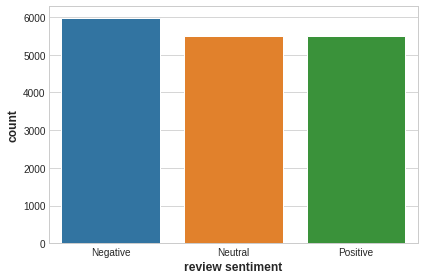

In [ ]:
ax = sns.countplot(df.Sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])

# Data Exploration

In [ ]:
df.columns

Index(['Date', 'Tweet', 'Sentiment'], dtype='object')

In [ ]:
tweets_per_hour = df['Date'].dt.strftime('%H').value_counts().sort_index().reset_index(name='counts')

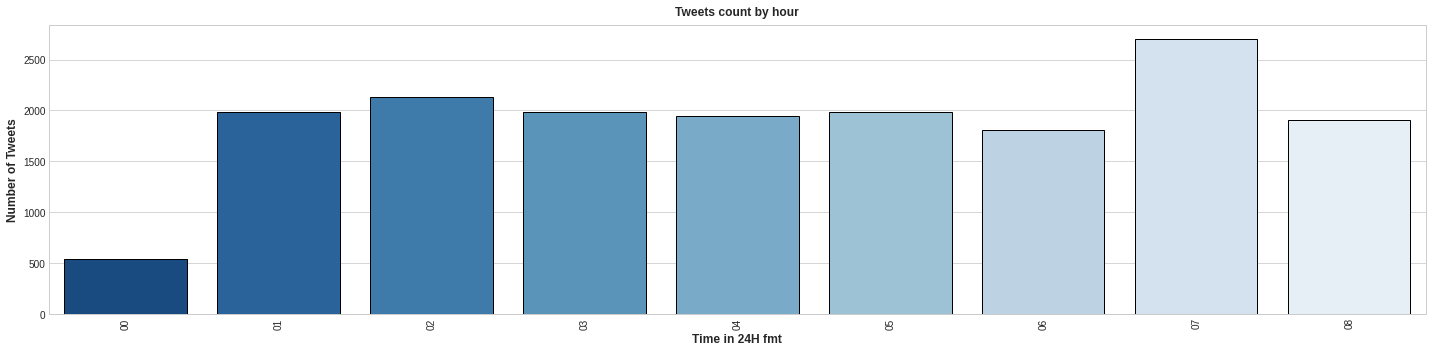

In [ ]:
plt.figure(figsize=(20,5))
ax = sns.barplot(x='index', y='counts', data=tweets_per_hour,edgecolor = 'black',ci=False, palette='YlOrBr')
plt.title('Tweets count by hour')
plt.ylabel('Number of Tweets')
plt.xlabel('Time in 24H fmt')
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#checking the hashtags
hash_re = re.compile(r'#\w+')

hash_dic = collections.defaultdict(int)

for t in tqdm(df['Tweet']):
    for w in t.split():
        if hash_re.fullmatch(w):
            hash_dic[w] +=1
tags_df = pd.DataFrame.from_dict(hash_dic,orient='index').rename(columns={0:'count'}).sort_values('count',ascending = False)

100%|██████████| 16983/16983 [00:00<00:00, 187165.62it/s]


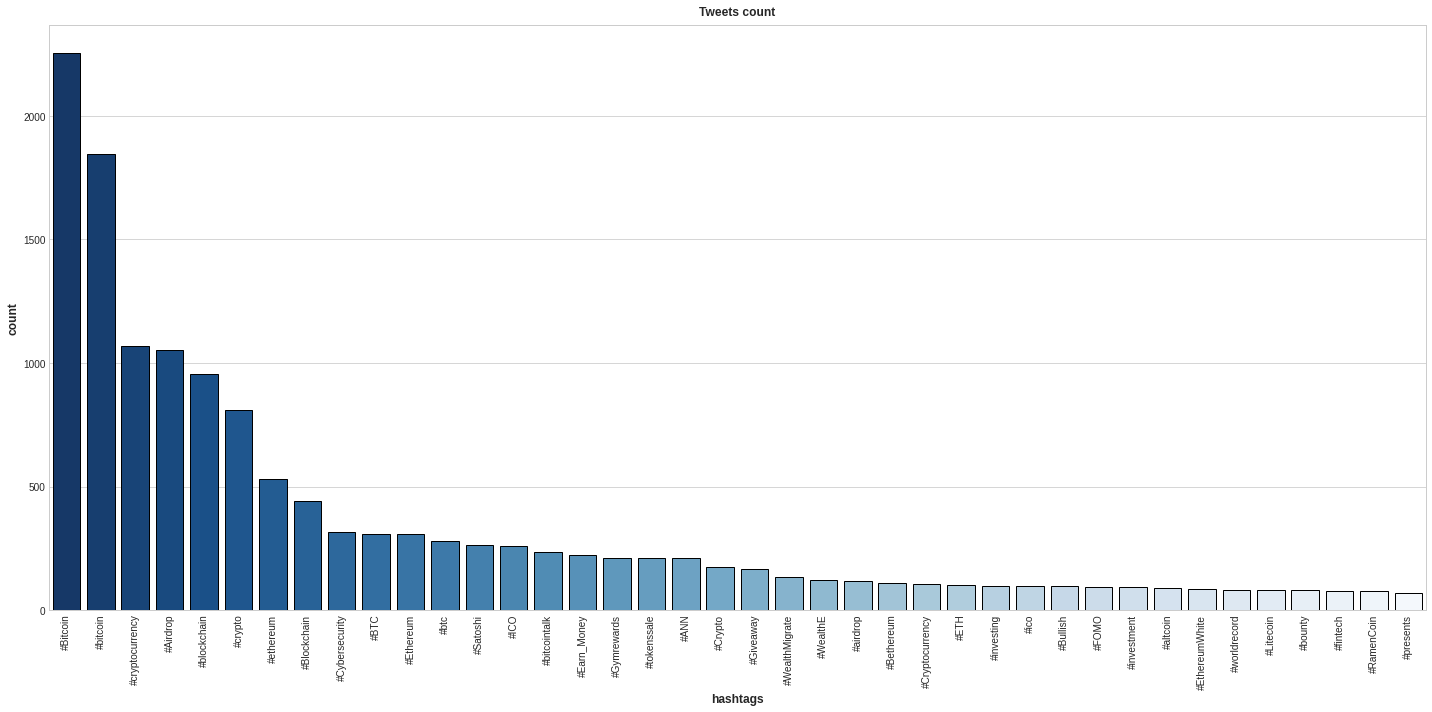

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = tags_df.index[:40], 
                 y = 'count',
                 data=tags_df[:40],
                 edgecolor = 'green',
                 ci=False, 
                 palette='YlOrBr')
plt.title('Tweets count')
plt.ylabel('count')
plt.xlabel('hashtags')
plt.xticks(rotation = 90)
plt.show()

## Cleaning the Dataframe 


Extracting the list of Cryptocoins and their names from the [website](https://www.cryptocompare.com). 

In [ ]:
import json
from bs4 import BeautifulSoup
import requests 

url = "https://www.cryptocompare.com/api/data/coinlist/"
res = requests.get(url)
soup = BeautifulSoup(res.content, "html.parser")
data = json.loads(soup.prettify())
data = data['Data']

In [ ]:
# looking at a particular instance
data.get('BTCD')

{'Id': '4400',
 'Url': '/coins/btcd/overview',
 'ImageUrl': '/media/19630/btcd_1.png',
 'ContentCreatedOn': 1427711372,
 'Name': 'BTCD',
 'Symbol': 'BTCD',
 'CoinName': 'BitcoinDark',
 'FullName': 'BitcoinDark (BTCD)',
 'Description': 'Bitcoin Dark (BTCD) is a PoW and PoS hybrid alternative cryptocurrency based on the same algorithm as Bitcoin itself - SHA256 - the difference is in the intent behind development - where Bitcoin is moving towards regulatory approval with increased transparency, BitcoinDark tries to push further of the belief of decentralization and anonymity. The block time is 60 seconds - there was a 1.5 premine and a total of 22 million coins are scheduled to be produced.Following the announcement of the Komodo Platform by the SuperNet team, BitcoinDark could be swapped for KMD coins and will be so until 2018. BTCD technology will be further advanced in the KMD platform.',
 'AssetTokenStatus': 'N/A',
 'Algorithm': 'SHA-256',
 'ProofType': 'PoW/PoS',
 'SortOrder': '13',

Since the coins can be present as symbols & names (irrespective of lower/upper case), we store these values in list_remove. Later this list is used to filter the tweets as these words dont associate with any emotion.

In [ ]:
list_remove = []
for key in data:
    list_remove.append(data[key].get('Name'))
    list_remove.append(data[key].get('CoinName').lower())
    list_remove.append(data[key].get('CoinName'))
print(list_remove[:40])


['BTCD', 'bitcoindark', 'BitcoinDark', 'CRAIG', 'craigscoin', 'CraigsCoin', 'XBS', 'bitstake', 'Bitstake', 'XPY', 'paycoin', 'PayCoin', 'PRC', 'prospercoin', 'ProsperCoin', 'YBC', 'ybcoin', 'YbCoin', 'DANK', 'darkkush', 'DarkKush', 'GIVE', 'givecoin', 'GiveCoin', 'KOBO', 'kobocoin', 'KoboCoin', 'DT', 'darktoken', 'DarkToken', 'CETI', 'cetus coin', 'CETUS Coin', 'SUP', 'supcoin', 'Supcoin', 'XPD', 'petrodollar', 'PetroDollar', 'GEO']


In [ ]:
list_remove.extend(['rt', 'retweet', 'Airdrop', 'airdrop'])

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

df = df[['Tweet','Sentiment']]
STOPWORDS = set(stopwords.words('english')).union(set(list_remove))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def strip_emoji(text):
    return clean(text, no_emoji=True) #remove emoji

def strip_stopwords(text):
  return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])


def strip_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    list_def= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    lab = str.maketrans('', '', list_def)
    text = text.translate(lab)
    return text

def clean_hashtags(tweet):
    n_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    n_tweet2 = " ".join(word.strip() for word in re.split('#|_', n_tweet))
    return n_tweet2

def filter_chars(a):
    s = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            s.append('')
        else:
            s.append(word)
    return ' '.join(s)

def remove_multii_spaces(text):
    return re.sub("\s\s+" , " ", text)
    

In [ ]:
texts_new = []
for t in df.Tweet:
    texts_new.append(remove_multii_spaces(filter_chars(clean_hashtags(strip_entities(strip_emoji(strip_stopwords(t)))))))

In [ ]:
df.head(2)

,Tweet,Sentiment
0,@vergecurrency Win 40000 verge. Rules:\n1.Retw...,2
1,Ethereum Price BOOST: Crypto values comeback v...,2


In [ ]:
df['text_clean'] = texts_new

#spectating 5 tweets before and after preprocessing
from prettytable import PrettyTable
t = PrettyTable(['Old text', 'CLeaned text'])
for i in range(5):
  t.add_row([df['Tweet'].iloc[i], df['text_clean'].iloc[i]])
print(t)

+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+
|                                                                  Old text                                                                 |                               CLeaned text                               |
+-------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------+
|                                                   @vergecurrency Win 40000 verge. Rules:                                                  |     win 40000 verge rules 1retweet like 2get android app 3 post wal      |
|                                                              1.Retweet, like.                                                     

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len

In [ ]:
df.head()

,Tweet,Sentiment,text_clean,text_len
0,@vergecurrency Win 40000 verge. Rules:\n1.Retw...,2,win 40000 verge rules 1retweet like 2get andro...,12
1,Ethereum Price BOOST: Crypto values comeback v...,2,price boost values comeback via convert btc et...,11
2,The latest The Poker Knave Daily! https://t.co...,2,latest poker knave daily bitcoin expat,6
3,Live Bitcoin Talk w/ Max Lee!\nhttps://t.co/gP...,2,live talk w max lee,5
4,"#Bitcoin rallies above $9,000 after positive G...",2,bitcoin rallies 9000 positive g20 cryptocurren...,10


Now looking at the wordcloud after removing all possible 

In [ ]:
import wordcloud
from wordcloud import WordCloud

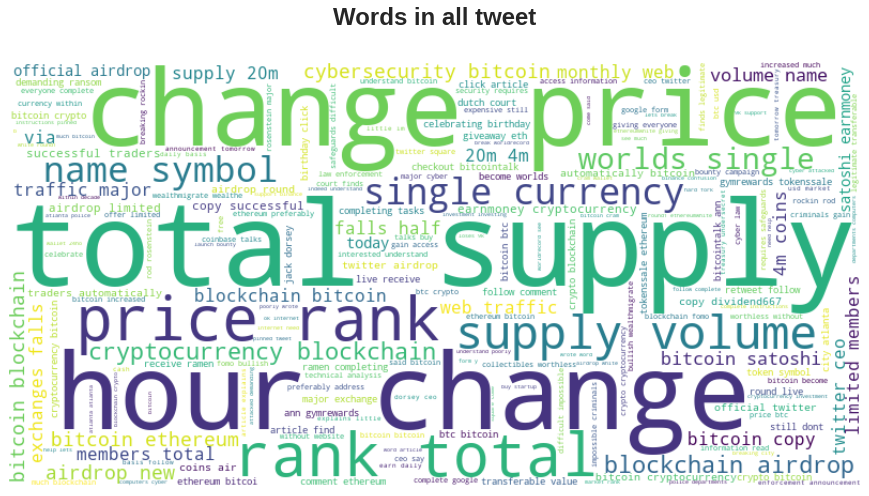

In [ ]:
words = ' '.join([text for text in df['text_clean']])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_font_size=110).generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

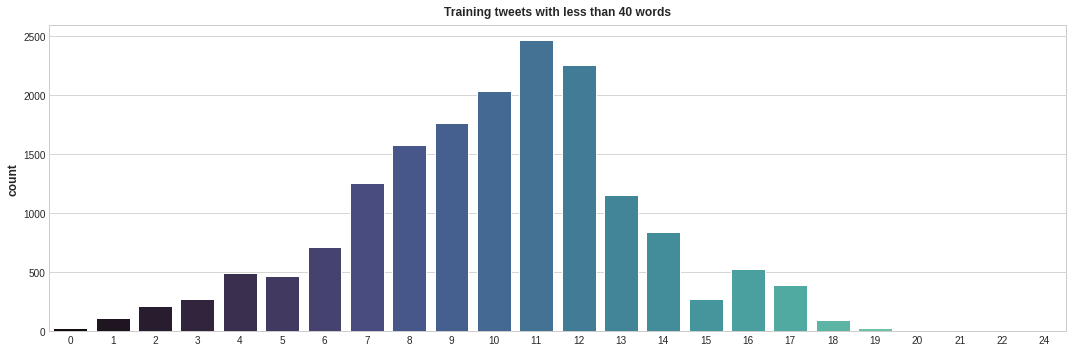

In [ ]:
plt.figure(figsize=(15,5))

ax = sns.countplot(x='text_len', data=df[df['text_len']<40], palette='mako')
plt.title('Training tweets with less than 40 words')
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (16983, 4)


In [ ]:
#picking rows having words greateer than 5
df = df[df['text_len'] > 5]
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (15399, 4)


## Training data deeper cleaning

We use BERT CASE UNCASED to tokenize the text.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
token_size = []

for txt in df['text_clean'].values:
    token = tokenizer.encode(txt, max_length=512, truncation=True)
    token_size.append(len(token))
    
max_len=np.max(token_size)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

MAX TOKENIZED SENTENCE LENGTH: 58


The long tokenized sentences (with more than 60 tokens ):

In [ ]:
token_size = []

for i,txt in enumerate(df['text_clean'].values):
    token = tokenizer.encode(txt, max_length=512, truncation=True)
    token_size.append(len(token))

In [ ]:
df['token_size'] = token_size
df = df.sort_values(by='token_size', ascending=False)
df.head(10)

,Tweet,Sentiment,text_clean,text_len,token_lens
7914,54c46c61ca70a4928d435d791a0085dd119b49ba229ae3...,1,54c46c61ca70a4928d435d791a0085dd119b49ba229ae3...,6,58
2819,New #bitcoin block 000000000000000000303b4f6ef...,2,new bitcoin block 000000000000000000303b4f6eff...,7,57
5681,403bccf9c8dd5e8452ba51a90801130c65b59174d2b950...,1,403bccf9c8dd5e8452ba51a90801130c65b59174d2b950...,6,57
3552,New #bitcoin block 0000000000000000000ddc396a7...,2,new bitcoin block 0000000000000000000ddc396a7e...,7,55
4498,New #bitcoin block 00000000000000000027de32b3c...,2,new bitcoin block 00000000000000000027de32b3c5...,7,55
1547,New #bitcoin block 0000000000000000004c95477f3...,2,new bitcoin block 0000000000000000004c95477f37...,7,55
68,New #bitcoin block 000000000000000000302f93f32...,2,new bitcoin block 000000000000000000302f93f324...,7,55
1465,New #bitcoin block 00000000000000000005d9276e0...,2,new bitcoin block 00000000000000000005d9276e02...,7,54
1004,New #bitcoin block 00000000000000000045b039632...,2,new bitcoin block 00000000000000000045b0396320...,7,53
6256,Valores | dolar R$3.3019 | BITCOIN(MCDTBC) R$3...,1,valores dolar r33019 bitcoinmcdtbc r3039735997...,9,51


In [ ]:
#shuffling the indices
df = df.sample(frac=1).reset_index(drop=True)

## Splitting the data into train-test

In [ ]:
df_train = df.sample(frac = 0.8)
df_test = df.drop(df_train.index)
df_train.shape

(12319, 5)

In [ ]:
df_test.shape

(3080, 5)

In [ ]:
ros = RandomOverSampler()
tr_x, tr_y = ros.fit_resample(np.array(df_train['text_clean']).reshape(-1, 1), np.array(df_train['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in tr_x], tr_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

2    4458
0    4458
1    4458
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [ ]:
X = df_train['text_clean'].values #features
y = df_train['Sentiment'].values #target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

one_hot_encoding = preprocessing.OneHotEncoder()
y_train = one_hot_encoding.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_test = one_hot_encoding.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_valid = one_hot_encoding.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()

TRAINING DATA: 11087
VALIDATION DATA: 1232
TESTING DATA: 3080


## Baseline model: Naive Bayes Classifier
Before implementing BERT, we will define a simple Naive Bayes baseline model to classify the tweets


In [ ]:
count_vector = CountVectorizer()
X_train_cv =  count_vector.fit_transform(X_train)
X_test_cv = count_vector.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_count_vector = MultinomialNB()

nb_count_vector.fit(X_train_tf, y_train_le)

nb_pred = nb_count_vector.predict(X_test_tf)

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.90      0.87      0.89      1137
     Neutral       0.85      0.81      0.83       896
    Positive       0.82      0.89      0.85      1047

    accuracy                           0.86      3080
   macro avg       0.86      0.86      0.86      3080
weighted avg       0.86      0.86      0.86      3080



## BERT Sentiment Analysis

In [ ]:

def tokenize(data,max_len=256) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

max_len = 256
train_input_ids, train_attention_masks = tokenize(X_train, max_len)
val_input_ids, val_attention_masks = tokenize(X_valid, max_len)
test_input_ids, test_attention_masks = tokenize(X_test, max_len)

# BERT modelling
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def create_model(bert_model, max_len=max_len):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-7, decay=1e-8)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model


model = create_model(bert_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=64)

Epoch 1/4
347/347 [==============================] - 287s 786ms/step - loss: 0.6117 - categorical_accuracy: 0.7410 - val_loss: 0.3478 - val_categorical_accuracy: 0.8734
Epoch 2/4
347/347 [==============================] - 271s 780ms/step - loss: 0.2674 - categorical_accuracy: 0.9057 - val_loss: 0.2875 - val_categorical_accuracy: 0.9099
Epoch 3/4
347/347 [==============================] - 271s 781ms/step - loss: 0.1566 - categorical_accuracy: 0.9478 - val_loss: 0.2771 - val_categorical_accuracy: 0.9107
Epoch 4/4
347/347 [==============================] - 271s 781ms/step - loss: 0.0962 - categorical_accuracy: 0.9700 - val_loss: 0.2799 - val_categorical_accuracy: 0.9188


In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

97/97 [==============================] - 28s 262ms/step


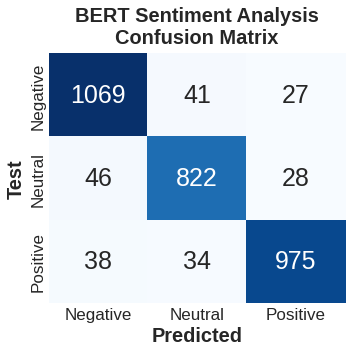

In [ ]:
# BERT Results
result_bert = model.predict([test_input_ids,test_attention_masks])

y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      1137
     Neutral       0.92      0.92      0.92       896
    Positive       0.95      0.93      0.94      1047

   micro avg       0.93      0.93      0.93      3080
   macro avg       0.93      0.93      0.93      3080
weighted avg       0.93      0.93      0.93      3080
 samples avg       0.93      0.93      0.93      3080



# RoBERTa Sentiment Analysis


In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

token_size = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_size.append(len(tokens))
max_length=np.max(token_size)
max_length

max_len=128

def tokenize_roberta(data,max_len=max_len) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

train_input_ids, train_attention_masks = tokenize_roberta(X_train, max_len)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, max_len)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, max_len)

def create_model(bert_model, max_len=max_len):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
370/370 [==============================] - 290s 745ms/step - loss: 0.5904 - categorical_accuracy: 0.7466 - val_loss: 0.3455 - val_categorical_accuracy: 0.8669
Epoch 2/4
370/370 [==============================] - 272s 735ms/step - loss: 0.2780 - categorical_accuracy: 0.9010 - val_loss: 0.2496 - val_categorical_accuracy: 0.9099
Epoch 3/4
370/370 [==============================] - 272s 736ms/step - loss: 0.1890 - categorical_accuracy: 0.9326 - val_loss: 0.2268 - val_categorical_accuracy: 0.9237
Epoch 4/4
370/370 [==============================] - 272s 735ms/step - loss: 0.1241 - categorical_accuracy: 0.9576 - val_loss: 0.2429 - val_categorical_accuracy: 0.9278


#### Roberta results

97/97 [==============================] - 27s 249ms/step


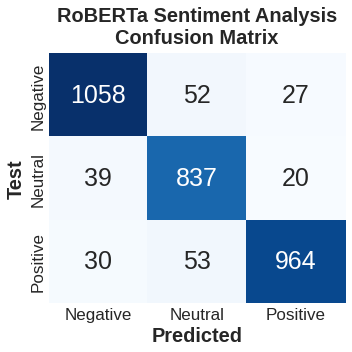

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:

print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      1137
     Neutral       0.89      0.93      0.91       896
    Positive       0.95      0.92      0.94      1047

   micro avg       0.93      0.93      0.93      3080
   macro avg       0.93      0.93      0.93      3080
weighted avg       0.93      0.93      0.93      3080
 samples avg       0.93      0.93      0.93      3080



# RESULT SUMMARY

In [ ]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.93      0.94      0.93      1137
     Neutral       0.92      0.92      0.92       896
    Positive       0.95      0.93      0.94      1047

   micro avg       0.93      0.93      0.93      3080
   macro avg       0.93      0.93      0.93      3080
weighted avg       0.93      0.93      0.93      3080
 samples avg       0.93      0.93      0.93      3080



In [ ]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

Classification Report for RoBERTa:
               precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      1137
     Neutral       0.89      0.93      0.91       896
    Positive       0.95      0.92      0.94      1047

   micro avg       0.93      0.93      0.93      3080
   macro avg       0.93      0.93      0.93      3080
weighted avg       0.93      0.93      0.93      3080
 samples avg       0.93      0.93      0.93      3080



Classification Matrix Comparison

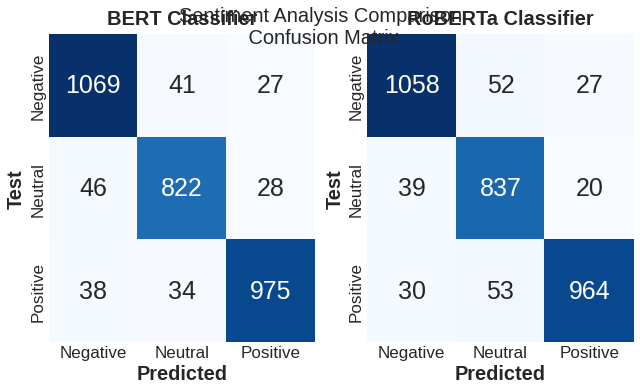

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="crest", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="crest", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()